## Data Augmentation with CIFAR-10

Import libs

In [50]:
import tensorflow as tf
from keras.datasets import cifar10
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

Same model building as other CIFAR-10

In [56]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

# Convert to float32 for scaling
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize data by scaling by max
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encode target labels and reshape
y_train = np_utils.to_categorical(y_train.transpose()).reshape(50000,10)
y_test = np_utils.to_categorical(y_test.transpose()).reshape(10000,10)
input_shape = (32,32,3)

print(f"Training set: {len(X_train)}\nTesting set: {len(X_test)}")

def build_cnn3(activation='relu', kernel_size=(3,3), pool_size=(2,2), regularizer=None, lam=0.01, summarize=False, dropout=False, drop_prob1=0.2, drop_prob2=0.2):
  model = Sequential()
  
  if regularizer == None:
    # Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=kernel_size, activation=activation, input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob1))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob2))

    # model.add(Conv2D(filters=256, kernel_size=kernel_size, activation=activation))
    # model.add(BatchNormalization())
    # if dropout:
    #   model.add(SpatialDropout2D(drop_prob2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation=activation))
    if dropout:
      model.add(Dropout(drop_prob2))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae','accuracy'])
    
    if summarize:
      model.build()
      model.summary()
    return model
  else:
    # Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=kernel_size, kernel_regularizer=regularizer(lam), activation=activation, input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, kernel_regularizer=regularizer(lam), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob1))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, kernel_regularizer=regularizer(lam), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob2))

    # model.add(Conv2D(filters=256, kernel_size=kernel_size, activation=activation))
    # model.add(BatchNormalization())
    # if dropout:
    #   model.add(SpatialDropout2D(drop_prob2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation=activation, kernel_regularizer=regularizer(lam)))
    if dropout:
      model.add(Dropout(drop_prob2))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae','accuracy'])

    if summarize:
      model.build()
      model.summary()
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Helper functions
def show_acc(history, e):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy/MAE')
  plt.legend()
  plt.show()
  
def build_and_plot3(activation='relu', kernel_size=(3,3), pool_size=(2,2), regularizer=None, lam=0.01, dropout=False, drop_prob1=0.2, drop_prob2=0.2, summarize=False, e=100, verbose=0):
  model = build_cnn3(activation=activation, kernel_size=kernel_size, pool_size=pool_size, regularizer=regularizer, lam=lam, dropout=dropout, drop_prob1=drop_prob1, drop_prob2=drop_prob2, summarize=summarize)
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=e, verbose=verbose, callbacks=[early_stopping])
  show_acc(history, e)
  print("Max accuracy: ", np.max(history.history['accuracy']))
  print("Min accuracy: ", np.min(history.history['accuracy']))
  print("Test performance ", model.evaluate(X_test, y_test))
  return model, history

Training set: 50000
Testing set: 10000


## Data Augmentation

Normal

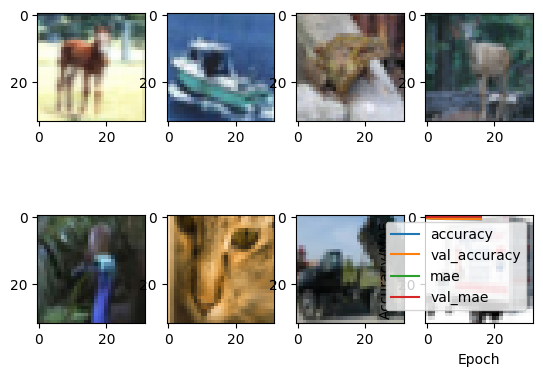

Max accuracy:  0.8172799944877625
Min accuracy:  0.4685800075531006
313/313 [==============================] - 3s 10ms/step - loss: 0.7693 - mae: 0.0586 - accuracy: 0.7643
Test performance  [0.7693300247192383, 0.05863118916749954, 0.7642999887466431]


(<keras.engine.sequential.Sequential at 0x2ed396d0310>,
 <keras.callbacks.History at 0x2ed399bb850>)

In [57]:
dataaug = ImageDataGenerator()
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Rotating Images

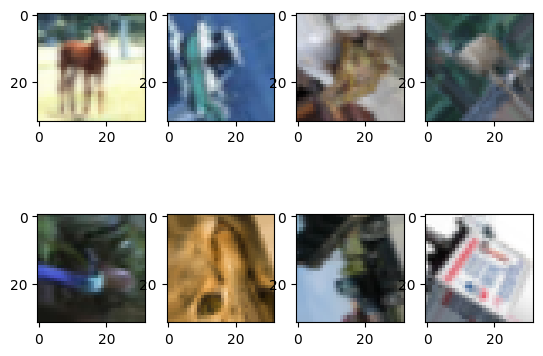

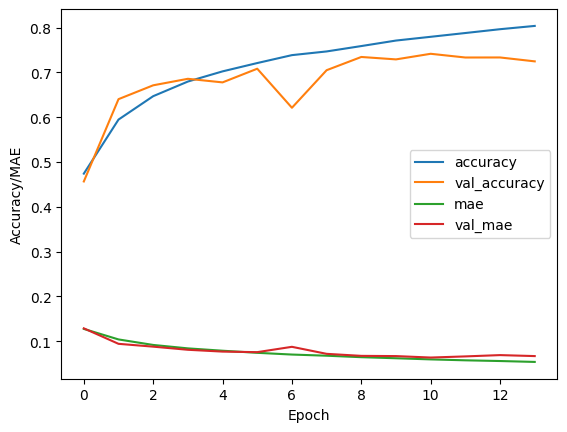

Max accuracy:  0.8035600185394287
Min accuracy:  0.4740400016307831
313/313 [==============================] - 3s 10ms/step - loss: 0.9093 - mae: 0.0671 - accuracy: 0.7245
Test performance  [0.9092812538146973, 0.0670621395111084, 0.7245000004768372]


(<keras.engine.sequential.Sequential at 0x2ed4865cdd0>,
 <keras.callbacks.History at 0x2ed486c59d0>)

In [62]:
dataaug = ImageDataGenerator(rotation_range=540)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Flip horizontally

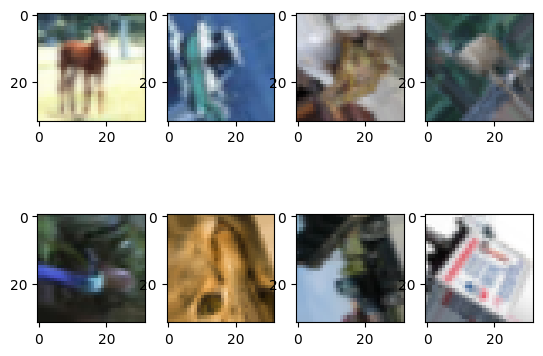

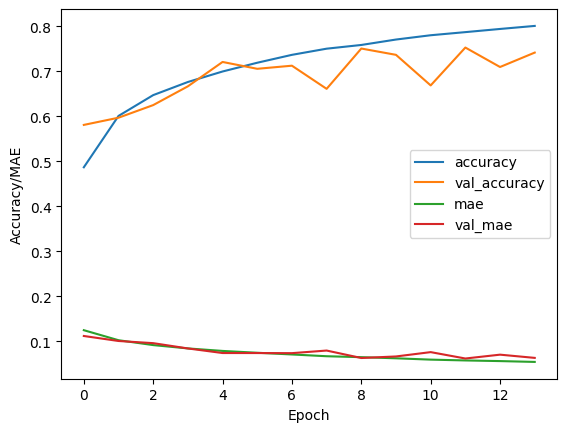

Max accuracy:  0.8007199764251709
Min accuracy:  0.4868200123310089
313/313 [==============================] - 3s 10ms/step - loss: 0.8356 - mae: 0.0635 - accuracy: 0.7415
Test performance  [0.8355888724327087, 0.06354167312383652, 0.7415000200271606]


(<keras.engine.sequential.Sequential at 0x2ed3b3bb310>,
 <keras.callbacks.History at 0x2ed55804b90>)

In [58]:
dataaug = ImageDataGenerator(rotation_range=540)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Add random noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


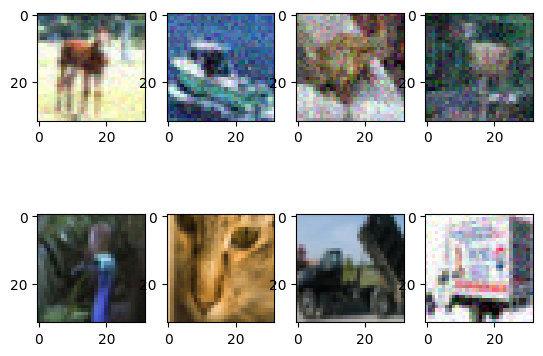

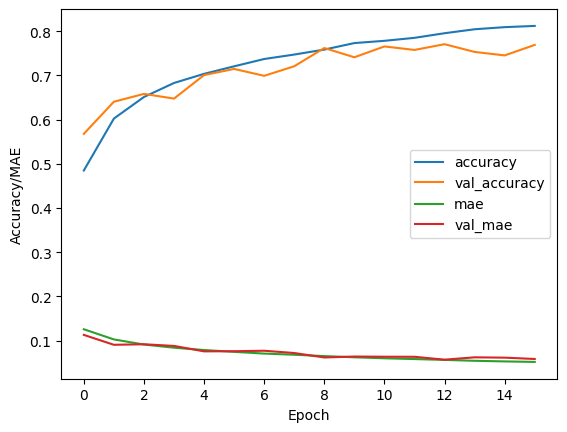

Max accuracy:  0.8119400143623352
Min accuracy:  0.4847800135612488
313/313 [==============================] - 3s 10ms/step - loss: 0.7732 - mae: 0.0583 - accuracy: 0.7690
Test performance  [0.7731711864471436, 0.05825602263212204, 0.7689999938011169]


(<keras.engine.sequential.Sequential at 0x2ed5832ed10>,
 <keras.callbacks.History at 0x2ed58356fd0>)

In [59]:
def noise(img):
    deviation = 0.08*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

dataaug = ImageDataGenerator(preprocessing_function=noise)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()
build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Apply filter

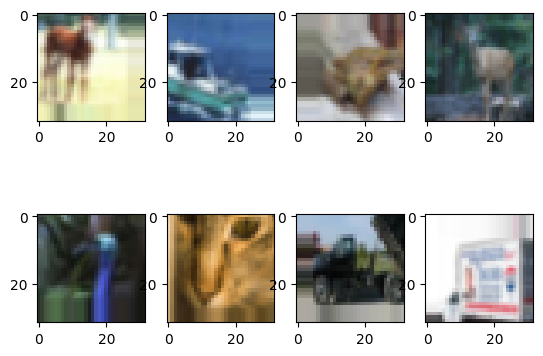

Epoch 1/100
1563/1563 - 54s - loss: 1.5011 - mae: 0.1276 - accuracy: 0.4743 - val_loss: 1.2007 - val_mae: 0.1117 - val_accuracy: 0.5735 - 54s/epoch - 35ms/step
Epoch 2/100
1563/1563 - 54s - loss: 1.1560 - mae: 0.1038 - accuracy: 0.5935 - val_loss: 1.3472 - val_mae: 0.1033 - val_accuracy: 0.5530 - 54s/epoch - 34ms/step
Epoch 3/100
1563/1563 - 54s - loss: 1.0249 - mae: 0.0925 - accuracy: 0.6452 - val_loss: 1.2790 - val_mae: 0.1004 - val_accuracy: 0.5789 - 54s/epoch - 35ms/step
Epoch 4/100
1563/1563 - 53s - loss: 0.9369 - mae: 0.0844 - accuracy: 0.6794 - val_loss: 1.1339 - val_mae: 0.0922 - val_accuracy: 0.6218 - 53s/epoch - 34ms/step
Epoch 5/100
1563/1563 - 54s - loss: 0.8857 - mae: 0.0798 - accuracy: 0.6982 - val_loss: 0.8882 - val_mae: 0.0780 - val_accuracy: 0.7027 - 54s/epoch - 35ms/step
Epoch 6/100
1563/1563 - 54s - loss: 0.8329 - mae: 0.0751 - accuracy: 0.7183 - val_loss: 1.0571 - val_mae: 0.0869 - val_accuracy: 0.6518 - 54s/epoch - 34ms/step
Epoch 7/100
1563/1563 - 53s - loss: 0.79

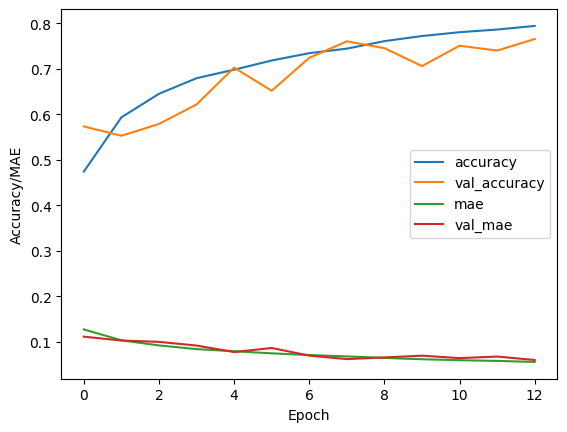

Max accuracy:  0.7942600250244141
Min accuracy:  0.4743399918079376
313/313 [==============================] - 3s 11ms/step - loss: 0.7623 - mae: 0.0605 - accuracy: 0.7655
Test performance  [0.7623001933097839, 0.06048498675227165, 0.765500009059906]


(<keras.engine.sequential.Sequential at 0x2ed5585e650>,
 <keras.callbacks.History at 0x2ed3b240c50>)

In [60]:
dataaug = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100, verbose=2)

Zoom

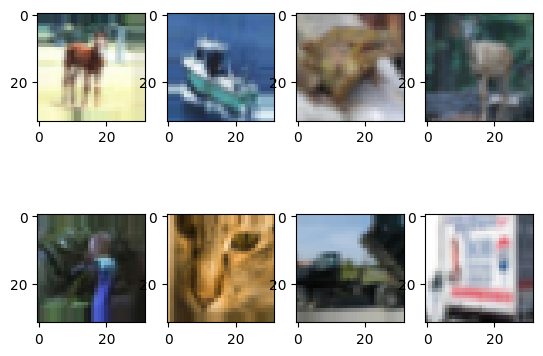

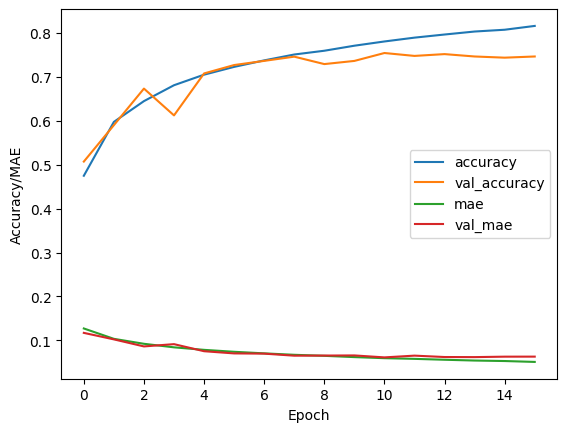

Max accuracy:  0.8157600164413452
Min accuracy:  0.4747200012207031
313/313 [==============================] - 3s 10ms/step - loss: 0.8267 - mae: 0.0631 - accuracy: 0.7462
Test performance  [0.8267340064048767, 0.06305520236492157, 0.7462000250816345]


(<keras.engine.sequential.Sequential at 0x2ed4fa72710>,
 <keras.callbacks.History at 0x2ed3f9eded0>)

In [61]:
dataaug = ImageDataGenerator(zoom_range=0.3)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)